In [32]:
import types
import pandas as pd
import quandl # import data

df_data_1 = quandl.get("OPEC/ORB", start_date="2003-01-01", end_date="2020-06-30")
df_data_1.head()


,Value
Date,
2003-01-02,30.05
2003-01-03,30.83
2003-01-06,30.71
2003-01-07,29.72
2003-01-08,28.86


Data Source

ข้อมูลราคาน้ำมันดิบในตลาดน้ำมันสหรัฐอเมริกา ตั้งแต่วันที่ 1 มกราคม ค.ศ 2003 ถึง 30 มิถุนายน ค.ศ. 2020 ซึ่งเป็นข้อมูลแบบรายวัน จากเว็บไซต์ https://www.quandl.com/data/OPEC/ORB-OPEC-Crude-Oil-Price

In [82]:
# if data has missing values use below code
# df_data_1 = df_data_1[df_data_1 != "."] 
print (df_data_1.shape)
print(df_data_1)

(4512, 1)
            Value
Date             
2003-01-02  30.05
2003-01-03  30.83
2003-01-06  30.71
2003-01-07  29.72
2003-01-08  28.86
...           ...
2020-06-24  38.17
2020-06-25  37.18
2020-06-26  37.99
2020-06-29  37.34
2020-06-30  38.22

[4512 rows x 1 columns]


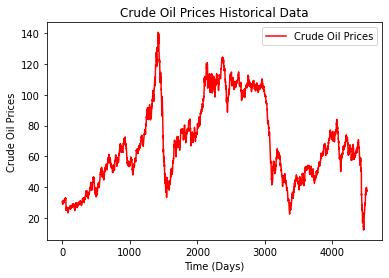

In [83]:
import matplotlib.pyplot as plt
df_data_1_plot = df_data_1.values
# print(df_data_1_plot)
# for i in range(len(df_data_1_plot)):
#     df_data_1_plot[i][0] = float(df_data_1_plot[i][0])
# Visualising the Data
plt.plot(df_data_1_plot, color = 'red', label = 'Crude Oil Prices')
plt.title('Crude Oil Prices Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [84]:
#import packages
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import load_model

In [233]:
# defining the batch size and number of epochs
batch_size = 64
epochs = 1000
timesteps = 15

In [234]:
length = len(df_data_1)
print (length)

#test set will be 10% of entire data set  
length *= 1 - 0.1
print (length)

4512
4060.8


In [235]:
#get the length of training data set 
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print (x)
    return (max(train_length_values))

In [236]:
length = get_train_length(df_data_1, batch_size, 0.1)
print (length)

3968
4032
4032


In [237]:
#Adding timesteps * 2
upper_train = length + timesteps*2
df_data_1_train = df_data_1[0:upper_train]
training_set = df_data_1_train.values
training_set.shape

(4062, 1)

In [238]:
# Feature Scaling i.e we scale each and every value between 0 and 1 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(4062, 1)

In [239]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print (length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print (len(X_train))
print (len (y_train))
print (np.array(X_train).shape)
print (np.array(y_train).shape)

4047
4032
4032
(4032, 15)
(4032, 15)


In [240]:
# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print (X_train.shape)
print (y_train.shape)

(4032, 15, 1)
(4032, 15, 1)


In [241]:
# Building the LSTM
# Importing the Keras libraries and packages

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.models import Model
import h5py

In [242]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(64, 15, 1)]             0         
_________________________________________________________________
lstm_20 (LSTM)               (64, 15, 10)              480       
_________________________________________________________________
lstm_21 (LSTM)               (64, 15, 10)              840       
_________________________________________________________________
dense_10 (Dense)             (64, 15, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [243]:
# 1st LSTM Layer 
parameters = 4 * 10 * (1 + 10 + 1)
print (parameters)

480


In [244]:
# 2nd LSTM Layer 
parameters = 4 * 10 * (10 + 10 + 1)
print( parameters)

840


In [245]:
print("Epoch: " + str(epochs))
for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mae.reset_states()

Epoch: 1000
Epoch: 0
4032/4032 [==============================] - 6s 1ms/sample - loss: 0.1076
Epoch: 1
4032/4032 [==============================] - 2s 605us/sample - loss: 0.0858
Epoch: 2
4032/4032 [==============================] - 2s 580us/sample - loss: 0.0837
Epoch: 3
4032/4032 [==============================] - 2s 562us/sample - loss: 0.0778
Epoch: 4
4032/4032 [==============================] - 2s 546us/sample - loss: 0.0700
Epoch: 5
4032/4032 [==============================] - 3s 662us/sample - loss: 0.0642
Epoch: 6
4032/4032 [==============================] - 2s 559us/sample - loss: 0.0593
Epoch: 7
4032/4032 [==============================] - 2s 550us/sample - loss: 0.0557
Epoch: 8
4032/4032 [==============================] - 2s 607us/sample - loss: 0.0536
Epoch: 9
4032/4032 [==============================] - 2s 553us/sample - loss: 0.0523
Epoch: 10
4032/4032 [==============================] - 2s 601us/sample - loss: 0.0515
Epoch: 11
4032/4032 [==============================] -

4032/4032 [==============================] - 2s 598us/sample - loss: 0.0407
Epoch: 96
4032/4032 [==============================] - 2s 611us/sample - loss: 0.0405
Epoch: 97
4032/4032 [==============================] - 2s 590us/sample - loss: 0.0405
Epoch: 98
4032/4032 [==============================] - 3s 650us/sample - loss: 0.0403
Epoch: 99
4032/4032 [==============================] - 3s 624us/sample - loss: 0.0403
Epoch: 100
4032/4032 [==============================] - 3s 681us/sample - loss: 0.0401
Epoch: 101
4032/4032 [==============================] - 2s 597us/sample - loss: 0.0402
Epoch: 102
4032/4032 [==============================] - 2s 601us/sample - loss: 0.0399
Epoch: 103
4032/4032 [==============================] - 3s 663us/sample - loss: 0.0401
Epoch: 104
4032/4032 [==============================] - 3s 628us/sample - loss: 0.0395
Epoch: 105
4032/4032 [==============================] - 3s 677us/sample - loss: 0.0401
Epoch: 106
4032/4032 [==============================] - 2s

4032/4032 [==============================] - 2s 615us/sample - loss: 0.0353
Epoch: 190
4032/4032 [==============================] - 3s 690us/sample - loss: 0.0351
Epoch: 191
4032/4032 [==============================] - 3s 728us/sample - loss: 0.0354
Epoch: 192
4032/4032 [==============================] - 2s 605us/sample - loss: 0.0358
Epoch: 193
4032/4032 [==============================] - 2s 552us/sample - loss: 0.0355
Epoch: 194
4032/4032 [==============================] - 2s 537us/sample - loss: 0.0351
Epoch: 195
4032/4032 [==============================] - 2s 576us/sample - loss: 0.0353
Epoch: 196
4032/4032 [==============================] - 2s 601us/sample - loss: 0.0352
Epoch: 197
4032/4032 [==============================] - 2s 578us/sample - loss: 0.0350
Epoch: 198
4032/4032 [==============================] - 2s 619us/sample - loss: 0.0352
Epoch: 199
4032/4032 [==============================] - 2s 558us/sample - loss: 0.0358
Epoch: 200
4032/4032 [==============================] 

4032/4032 [==============================] - 3s 633us/sample - loss: 0.0339
Epoch: 284
4032/4032 [==============================] - 2s 592us/sample - loss: 0.0337
Epoch: 285
4032/4032 [==============================] - 2s 611us/sample - loss: 0.0338
Epoch: 286
4032/4032 [==============================] - 2s 554us/sample - loss: 0.0335
Epoch: 287
4032/4032 [==============================] - 2s 596us/sample - loss: 0.0340
Epoch: 288
4032/4032 [==============================] - 2s 568us/sample - loss: 0.0346
Epoch: 289
4032/4032 [==============================] - 2s 545us/sample - loss: 0.0338
Epoch: 290
4032/4032 [==============================] - 2s 609us/sample - loss: 0.0335
Epoch: 291
4032/4032 [==============================] - 2s 545us/sample - loss: 0.0344
Epoch: 292
4032/4032 [==============================] - 2s 534us/sample - loss: 0.0347
Epoch: 293
4032/4032 [==============================] - 2s 579us/sample - loss: 0.0338
Epoch: 294
4032/4032 [==============================] 

4032/4032 [==============================] - 2s 536us/sample - loss: 0.0336
Epoch: 378
4032/4032 [==============================] - 2s 543us/sample - loss: 0.0335
Epoch: 379
4032/4032 [==============================] - 2s 570us/sample - loss: 0.0335
Epoch: 380
4032/4032 [==============================] - 2s 577us/sample - loss: 0.0335
Epoch: 381
4032/4032 [==============================] - 2s 567us/sample - loss: 0.0334
Epoch: 382
4032/4032 [==============================] - 2s 541us/sample - loss: 0.0333
Epoch: 383
4032/4032 [==============================] - 2s 530us/sample - loss: 0.0333
Epoch: 384
4032/4032 [==============================] - 2s 574us/sample - loss: 0.0333
Epoch: 385
4032/4032 [==============================] - 2s 538us/sample - loss: 0.0332
Epoch: 386
4032/4032 [==============================] - 2s 559us/sample - loss: 0.0333
Epoch: 387
4032/4032 [==============================] - 2s 579us/sample - loss: 0.0333
Epoch: 388
4032/4032 [==============================] 

4032/4032 [==============================] - 2s 579us/sample - loss: 0.0330
Epoch: 472
4032/4032 [==============================] - 2s 608us/sample - loss: 0.0330
Epoch: 473
4032/4032 [==============================] - 3s 627us/sample - loss: 0.0330
Epoch: 474
4032/4032 [==============================] - 2s 562us/sample - loss: 0.0332
Epoch: 475
4032/4032 [==============================] - 2s 608us/sample - loss: 0.0333
Epoch: 476
4032/4032 [==============================] - 3s 660us/sample - loss: 0.0334
Epoch: 477
4032/4032 [==============================] - 3s 762us/sample - loss: 0.0333
Epoch: 478
4032/4032 [==============================] - 3s 655us/sample - loss: 0.0333
Epoch: 479
4032/4032 [==============================] - 3s 699us/sample - loss: 0.0328
Epoch: 480
4032/4032 [==============================] - 3s 673us/sample - loss: 0.0333
Epoch: 481
4032/4032 [==============================] - 3s 642us/sample - loss: 0.0339
Epoch: 482
4032/4032 [==============================] 

4032/4032 [==============================] - 2s 554us/sample - loss: 0.0327
Epoch: 566
4032/4032 [==============================] - 2s 583us/sample - loss: 0.0328
Epoch: 567
4032/4032 [==============================] - 2s 571us/sample - loss: 0.0328
Epoch: 568
4032/4032 [==============================] - 2s 545us/sample - loss: 0.0326
Epoch: 569
4032/4032 [==============================] - 2s 595us/sample - loss: 0.0331
Epoch: 570
4032/4032 [==============================] - 2s 595us/sample - loss: 0.0329
Epoch: 571
4032/4032 [==============================] - 2s 575us/sample - loss: 0.0329
Epoch: 572
4032/4032 [==============================] - 2s 543us/sample - loss: 0.0327
Epoch: 573
4032/4032 [==============================] - 2s 539us/sample - loss: 0.0332
Epoch: 574
4032/4032 [==============================] - 2s 569us/sample - loss: 0.0327
Epoch: 575
4032/4032 [==============================] - 2s 539us/sample - loss: 0.0326
Epoch: 576
4032/4032 [==============================] 

4032/4032 [==============================] - 2s 602us/sample - loss: 0.0320
Epoch: 660
4032/4032 [==============================] - 3s 625us/sample - loss: 0.0323
Epoch: 661
4032/4032 [==============================] - 2s 545us/sample - loss: 0.0323
Epoch: 662
4032/4032 [==============================] - 2s 598us/sample - loss: 0.0325
Epoch: 663
4032/4032 [==============================] - 2s 608us/sample - loss: 0.0320
Epoch: 664
4032/4032 [==============================] - 2s 541us/sample - loss: 0.0318
Epoch: 665
4032/4032 [==============================] - 2s 597us/sample - loss: 0.0315
Epoch: 666
4032/4032 [==============================] - 2s 535us/sample - loss: 0.0314
Epoch: 667
4032/4032 [==============================] - 2s 581us/sample - loss: 0.0315
Epoch: 668
4032/4032 [==============================] - 2s 553us/sample - loss: 0.0315
Epoch: 669
4032/4032 [==============================] - 2s 540us/sample - loss: 0.0310
Epoch: 670
4032/4032 [==============================] 

4032/4032 [==============================] - 3s 653us/sample - loss: 0.0314
Epoch: 754
4032/4032 [==============================] - 3s 649us/sample - loss: 0.0303s - loss
Epoch: 755
4032/4032 [==============================] - 2s 601us/sample - loss: 0.0299
Epoch: 756
4032/4032 [==============================] - 2s 603us/sample - loss: 0.0307
Epoch: 757
4032/4032 [==============================] - 3s 679us/sample - loss: 0.0304
Epoch: 758
4032/4032 [==============================] - 2s 603us/sample - loss: 0.0302
Epoch: 759
4032/4032 [==============================] - 3s 628us/sample - loss: 0.0306
Epoch: 760
4032/4032 [==============================] - 3s 698us/sample - loss: 0.0301
Epoch: 761
4032/4032 [==============================] - 3s 665us/sample - loss: 0.0301
Epoch: 762
4032/4032 [==============================] - 3s 696us/sample - loss: 0.0308
Epoch: 763
4032/4032 [==============================] - 3s 634us/sample - loss: 0.0300
Epoch: 764
4032/4032 [========================

4032/4032 [==============================] - 2s 549us/sample - loss: 0.0302
Epoch: 848
4032/4032 [==============================] - 2s 569us/sample - loss: 0.0305
Epoch: 849
4032/4032 [==============================] - 2s 546us/sample - loss: 0.0297
Epoch: 850
4032/4032 [==============================] - 2s 570us/sample - loss: 0.0291
Epoch: 851
4032/4032 [==============================] - 2s 540us/sample - loss: 0.0291
Epoch: 852
4032/4032 [==============================] - 2s 537us/sample - loss: 0.0304
Epoch: 853
4032/4032 [==============================] - 3s 621us/sample - loss: 0.0304
Epoch: 854
4032/4032 [==============================] - 2s 534us/sample - loss: 0.0298
Epoch: 855
4032/4032 [==============================] - 2s 599us/sample - loss: 0.0298
Epoch: 856
4032/4032 [==============================] - 3s 630us/sample - loss: 0.0305
Epoch: 857
4032/4032 [==============================] - 2s 537us/sample - loss: 0.0310
Epoch: 858
4032/4032 [==============================] 

4032/4032 [==============================] - 2s 577us/sample - loss: 0.0298
Epoch: 942
4032/4032 [==============================] - 3s 751us/sample - loss: 0.0294
Epoch: 943
4032/4032 [==============================] - 2s 551us/sample - loss: 0.0290
Epoch: 944
4032/4032 [==============================] - 3s 643us/sample - loss: 0.0300
Epoch: 945
4032/4032 [==============================] - 3s 668us/sample - loss: 0.0304
Epoch: 946
4032/4032 [==============================] - 3s 722us/sample - loss: 0.0308
Epoch: 947
4032/4032 [==============================] - 3s 703us/sample - loss: 0.0295
Epoch: 948
4032/4032 [==============================] - 2s 601us/sample - loss: 0.0298
Epoch: 949
4032/4032 [==============================] - 3s 687us/sample - loss: 0.0301
Epoch: 950
4032/4032 [==============================] - 2s 552us/sample - loss: 0.0298
Epoch: 951
4032/4032 [==============================] - 2s 567us/sample - loss: 0.0294
Epoch: 952
4032/4032 [==============================] 

In [246]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print (x)
    return (max(test_length_values))

In [247]:
test_length = get_test_length(df_data_1, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print (testset_length)

4318
4382
4446
4446
384


In [248]:
print (upper_train, upper_test, len(df_data_1))

4062 4476 4512


In [249]:
# construct test set

#subsetting
df_data_1_test = df_data_1[upper_train:upper_test] 
test_set = df_data_1_test.values

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [250]:
#prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print (predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print (predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print (y_test.shape)

(384, 15, 1)
(384, 15)
(369, 1)


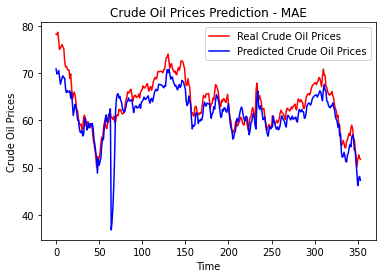

In [251]:
# Visualising the results
plt.plot(test_set[timesteps:len(y_test)], color = 'red', label = 'Real Crude Oil Prices')
plt.plot(y_test[0:len(y_test) - timesteps], color = 'blue', label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [252]:

import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

3.4623220636148173


In [253]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mae)

2.50230238747462


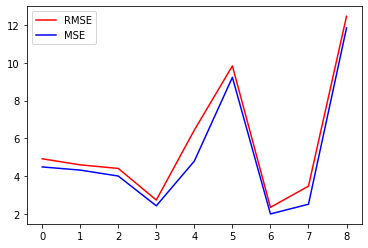

In [256]:
import matplotlib.pyplot as plt
rmse = [4.910834388695306, 4.590208411188218,  4.399262406769295, 2.724577831484447, 6.433807319938271, 9.833775656861546, 2.338725747531054, 3.4623220636148173, 12.465757352808414]
mse =  [4.479323504373907, 4.3114167897714735, 3.9968361347339765, 2.4194256963686307, 4.789625124742756, 9.228935468820426, 1.988993456243924, 2.50230238747462, 11.848299762432392]
plt.plot(rmse, color = 'red', label = 'RMSE')
plt.plot(mse, color = 'blue', label = 'MSE')
plt.legend()
plt.show()